# The Jets Collection

The Jets collections

In [1]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21
import matplotlib.pyplot as plt
from config import rucio_zee_r21_mc, xAODLocalTyped, local_xaod_path
import awkward as ak
import numpy as np

In [2]:
#ds = SXDSAtlasxAODR21(rucio_zee_r21_mc, backend='dev_xaod')
ds = xAODLocalTyped(local_xaod_path)

Found backend type matching "xaod". Matching by type is depreciated. Please switch to using the "name" keyword in your servicex.yaml file.


In [3]:
jets = (ds
        .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets"))
        .Where(lambda j: (j.pt() / 1000) > 30)
        .Select(lambda j: j.pt() / 1000.0)
        .AsAwkwardArray('JetPt')
        .value())

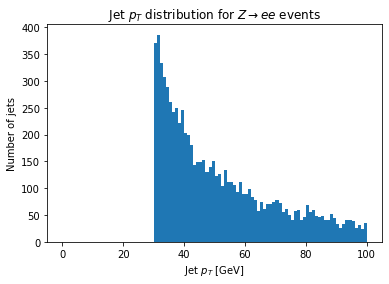

In [4]:
plt.hist(jets.JetPt, bins=100, range=(0, 100))
plt.xlabel('Jet $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet $p_T$ distribution for $Z\\rightarrow ee$ events')

## Jet Constituents

Jets are composed of `TopoClusters` in ATLAS, and the AntiKt algorithm normally clusters them into a jet. In R21 files, the `TopoClusters` are easily accessible.

In [5]:
topo_clusters = (ds
                    .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets"))
                    .SelectMany(lambda j: j.getConstituents())
                    .Select(lambda tc: tc.pt())
                    .AsAwkwardArray('JetClusterPt')
                    .value()
                )

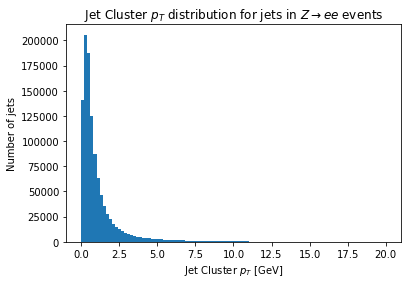

In [6]:
plt.hist(topo_clusters.JetClusterPt/1000.0, bins=100, range=(0, 20))
plt.xlabel('Jet Cluster $p_T$ [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('Jet Cluster $p_T$ distribution for jets in $Z\\rightarrow ee$ events')

## Calibration

By default the jets we pulled from above are calibrated, and the best central value for the jet collection you request is returned. This section shows you how to:

* Pull out the raw, uncalibrated jets
* How to get a particular systematic variation
* How to use a particular calibration for the jets

Because we want to do a comparison, and the jet corrections change the number of jets, we will need to do jet matching. Lets get the default calibration with eta and phi:

In [7]:
jets = (ds
        .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets"))
        .Where(lambda j: (j.pt() / 1000) > 30)
        .Select(lambda j: {
            'pt': j.pt() / 1000.0,
            'eta': j.eta(),
            'phi': j.phi(),
        })
        .AsAwkwardArray()
        .value())

To grab the raw jets (without calibration) we just set the `calibrated` parameter to `False` (there is very little reason one will do this normally):

In [8]:
raw_jets = (ds
           .SelectMany(lambda e: e.Jets("AntiKt4EMTopoJets", calibrated=False))
           .Where(lambda j: (j.pt() / 1000) > 30)
           .Select(lambda j: {
               'pt': j.pt() / 1000.0,
               'eta': j.eta(),
               'phi': j.phi(),
           })
           .AsAwkwardArray()
           .value())

The number of raw jets and the number of calibrated jets are quite different from the number of raw jets, so we'll need to match them in $\eta$ and $\phi$:

In [9]:
len(raw_jets), len(jets)

(27483, 10708)

In [10]:
def match(jets, jets_to_match):
    'Find the closest eta/phi jet in jets_to_match for each jet in jets'

    by_jets = ak.cartesian([jets, jets_to_match], axis=0, nested=True)
    d_eta = np.abs(by_jets[:, :]["0"].eta - by_jets[0, :]["1"].eta)
    # TODO: Account for wrap around
    d_phi = np.abs(by_jets[:, :]["0"].phi - by_jets[0, :]["1"].phi)
    delta = d_eta + d_phi

    # TODO: Window out any match over 0.2*0.2 in eta/phi
    best_match = ak.argmin(delta, axis=1)
    return jets_to_match[best_match]

raw_jets_matched = match(jets, raw_jets)

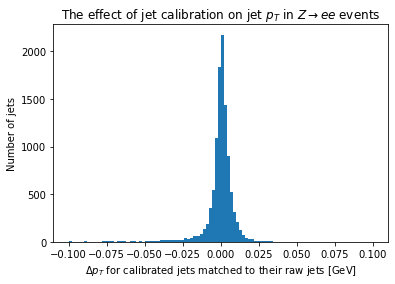

In [11]:
plt.hist((jets.pt-raw_jets_matched.pt)/1000.0, bins=100, range=(-0.1, 0.1))
plt.xlabel('$\Delta p_T$ for calibrated jets matched to their raw jets [GeV]')
plt.ylabel('Number of jets')
_ = plt.title('The effect of jet calibration on jet $p_T$ in $Z\\rightarrow ee$ events')

## The Datamodel

The data model when this documentation was last built was:

In [12]:
from func_adl_servicex_xaodr21.xAOD.jet_v1 import Jet_v1
help(Jet_v1)

Help on class Jet_v1 in module func_adl_servicex_xaodr21.xAOD.jet_v1:

class Jet_v1(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  Jet_v1(self) -> 'func_adl_servicex_xaodr21.xAOD.jet_v1.Jet_v1'
 |      A method
 |  
 |  btagging(self) -> 'func_adl_servicex_xaodr21.xAOD.btagging_v1.BTagging_v1'
 |      A method
 |  
 |  btaggingLink(self) -> 'func_adl_servicex_xaodr21.elementlink_datavector_xaod_btagging_v1__.ElementLink_DataVector_xAOD_BTagging_v1__'
 |      A method
 |  
 |  clearDecorations(self) -> 'bool'
 |      A method
 |  
 |  constituentLinks(self) -> 'func_adl_servicex_xaodr21.vector_elementlink_datavector_xaod_iparticle___.vector_ElementLink_DataVector_xAOD_IParticle___'
 |      A method
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  getConstituents(self) -> 'func_adl_servicex_xaodr21.xAOD.jetconstituentvector.JetConstituentVector'
 |      A method
 |  
 |  getSizeParameter(self) -> 'float'
 |      A 

In [13]:
from func_adl_servicex_xaodr21.xAOD.jetconstituent import JetConstituent
help(JetConstituent)

Help on class JetConstituent in module func_adl_servicex_xaodr21.xAOD.jetconstituent:

class JetConstituent(builtins.object)
 |  A class
 |  
 |  Methods defined here:
 |  
 |  e(self) -> 'float'
 |      A method
 |  
 |  eta(self) -> 'float'
 |      A method
 |  
 |  isSpacelike(self) -> 'bool'
 |      A method
 |  
 |  isTimelike(self) -> 'bool'
 |      A method
 |  
 |  m(self) -> 'float'
 |      A method
 |  
 |  phi(self) -> 'float'
 |      A method
 |  
 |  pt(self) -> 'float'
 |      A method
 |  
 |  rapidity(self) -> 'float'
 |      A method
 |  
 |  rawConstituent(self) -> 'func_adl_servicex_xaodr21.xAOD.iparticle.IParticle'
 |      A method
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Further Information

* The [`xAOD::Jet_v1` C++ header file](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/versions/Jet_v1.h) with all the inline documentation.
* The [`xAOD::JetConstituent` C++ header File](https://gitlab.cern.ch/atlas/athena/-/blob/21.2/Event/xAOD/xAODJet/xAODJet/JetConstituentVector.h) with all the inline documentation.